# Set-up

## Package management

In [1]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---
from cdlib import algorithms
import networkx as nx

# --- Data handling and visualization ---

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# --- Project source code ---
sys.path.append("../")
sys.path.append("../src/")

# Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import lfr_multiplex  # benchmark samplers

# Sampling
from src.sampling.random import partial_information  # PFI observation

# Embedding
from src.embed.LE import LE

# Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

# Utils
from src.utils.parameters import set_parameters_LE

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'karateclub', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


## Global config

In [2]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"

In [3]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

---

# Experiment

## Function set-up

In [4]:
def community_finder (G):
    # >>> Book-keeping >>>
    sigma = {}
    c = 0

    # <<< Book-keeping <<<

    # >>> Community detection >>>
    # Apply community detection to network
    C = algorithms.louvain(G)

    # Form node -> community_id mapping
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1

    # Estimate community strength
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
    # <<< Community detection <<<

    return sigma, mu, tot

def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):
         # >>> DC Classifier >>>
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)


        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)

        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)

            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            if show_log == True:
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< DC Classifier <<<


    # >>> D Classifier >>>
    if TT == 1:
        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            s2 = rem_G2.degree(n)*rem_G2.degree(m)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< D Classifier <<<

def perform_analysis (G1, G2, step, TT = 0):

    # >>> Book-keeping >>>
    x , y, z  = [], [], []
    frac = 0.0
    # <<< Book-keeping <<<

    # >>> Sweep over relative size of training set >>>
    while frac < 1.0:
        if frac <= 1.0 - step:
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))

            # Observe information
            rem_G1, rem_G2, Etest, Etrain  = partial_information (G1, G2, frac)

            # Reconstruct multiplex
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)

            # Measure reconstruction performance
            acc = accuracy_score(ground_truth, classification)
            auc = roc_auc_score(ground_truth, scores)

            x.append(frac)
            y.append(acc)
            z.append(auc)

        frac += step
    # <<< Sweep over relative size of training set <<<

    results = [x, y, z]
    return results

In [5]:
def renormalize_embedding_per_component (G, n2v_emb):
    n2v_emb_rescaled = {}
    for n in G:
        n2v_emb_rescaled[n] = n2v_emb.wv[str(n)]

    nr_comp = 0
    components = nx.connected_components(G)
    for c in components:
        nr_comp += 1
        list_of_nodes = []
        norm = 0.0
        for n in c:
            list_of_nodes.append(n2v_emb_rescaled[n])
        cm = np.add.reduce(list_of_nodes) / float(len(list_of_nodes))
        for n in c:
            n2v_emb_rescaled[n] = n2v_emb_rescaled[n] - cm
            norm += np.linalg.norm(n2v_emb_rescaled[n])
        if norm > 0.0:
            for n in c:
                n2v_emb_rescaled[n] = n2v_emb_rescaled[n] / norm

    return n2v_emb_rescaled

In [6]:
def embedding_classifier (Etest, rem_G1, emb_rescaled_1, rem_G2, emb_rescaled_2, log_regression, penalty, option):

#     print('#Intercept = ', log_regression.intercept_[0])
#     print('#Degree coefficient = ', log_regression.coef_[0][0])
#     print('#Embedding coefficient = ', log_regression.coef_[0][1])

    classification, scores, ground_truth = [], [], []



    for e in Etest:
        n = e[0]
        m = e[1]


        ##degree
        s1 = rem_G1.degree(n)*rem_G1.degree(m)
        s2 = rem_G2.degree(n)*rem_G2.degree(m)

        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)
        t1 = 2.0*t1-1.0
        t2 = 2.0*t2-1.0
        ##embedding

        es1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        es2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        et1 = et2 = 0.5
        if es1 + es2 > 0.0:
            et1 = es1 / (es1 + es2)
            et2 = es2 / (es1 + es2)
        et1 = 2.0*et1-1.0
        et2 = 2.0*et2-1.0
        ###########


        if option == 1:
#             print ('# option 1 , degree only')
            prob1 = log_regression.coef_[0][0] * t1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 2:
#             print ('# option 2 , degree + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * t1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 3:
#             print ('# option 3 , embedding only')
            prob1 = log_regression.coef_[0][0] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 4:
#             print ('# option 4 , embedding + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 5:
#             print ('# option 5 , degree + embedding')
            prob1 = log_regression.coef_[0][0] * t1 + log_regression.coef_[0][1] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 6:
#             print ('# option 6 , degree + embedding + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * t1 + log_regression.coef_[0][1] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1



        s = random.randint(0,1)
        if prob1 > prob2:
            s = 1
        if prob2 > prob1:
            s = 0



        scores.append(prob1)
        classification.append(s)
        ground_truth.append(Etest[e])



    return classification, scores, ground_truth


In [7]:
def score_edges_training (rem_G1, emb_rescaled_1, rem_G2, emb_rescaled_2, penalty):


    ####################################
    degree_score = {}
    emb_score = {}
    ground_truth = {}

    for e in rem_G1.edges():

        n = e[0]
        m = e[1]

        tmp1 = rem_G1.degree(n)*rem_G1.degree(m)
        tmp2 = rem_G2.degree(n)*rem_G2.degree(m)

        stmp1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        stmp2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        if n < m:
            degree_score[n,m] = tmp1/(tmp1+tmp2)
            emb_score[n,m] = stmp1/(stmp1+stmp2)
            ground_truth[n,m] = 1
        else:
            degree_score[m,n] = tmp1/(tmp1+tmp2)
            emb_score[m,n] = stmp1/(stmp1+stmp2)
            ground_truth[m,n] = 1


    for e in rem_G2.edges():

        n = e[0]
        m = e[1]

        tmp1 = rem_G1.degree(n)*rem_G1.degree(m)
        tmp2 = rem_G2.degree(n)*rem_G2.degree(m)

        stmp1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        stmp2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        if n < m:
            degree_score[n,m] = tmp1/(tmp1+tmp2)
            emb_score[n,m] = stmp1/(stmp1+stmp2)
            ground_truth[n,m] = 0
        else:
            degree_score[m,n] = tmp1/(tmp1+tmp2)
            emb_score[m,n] = stmp1/(stmp1+stmp2)
            ground_truth[m,n] = 0
    ###########################

#     for e in degree_score:
#         print (e, degree_score[e], emb_score[e], ground_truth[e])

    return degree_score, emb_score, ground_truth

In [8]:
def perform_logisitic_regression (degree_score, emb_score, ground_truth, option):

    list_of_edges = list(degree_score.keys())

    #degree only
    if option == 1 or option == 2:

        X = np.zeros((len(list_of_edges),1))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*degree_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 1:
            print ('# option 1 , degree only')
            log_regression = LogisticRegression(fit_intercept=False, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Degree coefficient = ', log_regression.coef_[0][0])

        if option == 2:
            print ('# option 2 , degree + intercept')
            log_regression = LogisticRegression(fit_intercept=True, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Degree coefficient = ', log_regression.coef_[0][0])

        return log_regression



    #embedding only
    if option == 3 or option == 4:

        X = np.zeros((len(list_of_edges),1))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*emb_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 3:
            print ('# option 3 , embedding only')
            log_regression = LogisticRegression(fit_intercept=False, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Embedding coefficient = ', log_regression.coef_[0][0])

        if option == 4:
            print ('# option 4 , embedding + intercept')
            log_regression = LogisticRegression(fit_intercept=True,  penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Embedding coefficient = ', log_regression.coef_[0][0])

        return log_regression





    if option == 5 or option == 6:

        X = np.zeros((len(list_of_edges),2))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*degree_score[list_of_edges[i]]-1.0
            X[i][1] = 2.0*emb_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 5:
            print ('# option 5 , degree + embedding')
            log_regression = LogisticRegression(fit_intercept=False,  penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Degree coefficient = ', log_regression.coef_[0][0])
            print('#Embedding coefficient = ', log_regression.coef_[0][1])

        if option == 6:
            log_regression = LogisticRegression(fit_intercept=True, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Degree coefficient = ', log_regression.coef_[0][0])
            print('#Embedding coefficient = ', log_regression.coef_[0][1])

        return log_regression

In [9]:
def perform_analysis_embedding (G1, G2, step, option = 1, penalty = 0.1):



    x , y, z  = [], [], []


    frac = step
    while frac < 1.0:

        if frac <= 1.0 - step:

            print('\n\nFrac ', frac)

            rem_G1, rem_G2, Etest, Etrain  = partial_information (G1, G2, frac)

            node2vec1 = Node2Vec(rem_G1, dimensions=62, walk_length=20, num_walks=10, workers=16)
            node2vec2 = Node2Vec(rem_G2, dimensions=64, walk_length=20, num_walks=10, workers=16)

            model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)
            model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

            n2v_emb_rescaled_1 = renormalize_embedding_per_component (rem_G1, model1)
            n2v_emb_rescaled_2 = renormalize_embedding_per_component (rem_G2, model2)

            degree_score, emb_score, ground_truth = score_edges_training (rem_G1, n2v_emb_rescaled_1, rem_G2, n2v_emb_rescaled_2, penalty)


            log_regression = perform_logisitic_regression (degree_score, emb_score, ground_truth, option)

            classification, scores, ground_truth = embedding_classifier (Etest, rem_G1, n2v_emb_rescaled_1, rem_G2, n2v_emb_rescaled_2, log_regression, penalty, option)

            acc = accuracy_score(ground_truth, classification)
            auc = roc_auc_score(ground_truth, scores)



            x.append(frac)
            y.append(acc)
            z.append(auc)


        frac += step


    results = [x, y, z]
    return results

## Data set-up

### Specify parameters

In [10]:
_DATA_DICT = {
    "N": "number of nodes (in shared node set)",
    "GAMMA": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "AVG_K": "average degree (in both layers)",
    "T1": "equivalent to GAMMA for LFR models",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [11]:
class NetworkParams(Enum):
    # Shared params
    N = 1_000
    PROB = 1.0
    GAMMA = 2.1
    KMAX = np.sqrt(1_000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    AVG_K = 6.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

In [12]:
class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 10, endpoint=True)

In [13]:
LOGREG = {"fit_intercept": True, "solver": "newton-cholesky", "penalty": None}

### Sample duplex

In [14]:
duplex, _, _, _ = lfr_multiplex(
    int(NetworkParams.N.value),  # number of nodes
    NetworkParams.GAMMA.value,  # degree distribution exponent
    NetworkParams.T2.value,  # community size distribution exponent
    NetworkParams.MU.value,  # community mixing parameter
    NetworkParams.AVG_K.value,  # average degree
    NetworkParams.KMAX.value,  # maximum degree
    NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
    NetworkParams.PROB.value,  # degree sequence correlation,
    ROOT="../"
)

In [15]:
G, H = duplex_network(duplex, 1, 2, verbose=True)

Number of common edges removed: 21
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


### Compute remnants

In [16]:
remnants = dict()  # theta -> [remnants infomation] mapping
for theta in ExperimentParams.THETAS.value:
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }
    remnants[theta] = record

## Feature calculation

In [17]:
features = dict()  # theta -> [train features, test features]
labels = dict()  # theta -> [train labels, test labels]

In [18]:
for theta, record in remnants.items():
    # --- Degree feature ---
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees(record["remnants"], list(record["observed_edges"].keys()))
    src_degrees_test, tgt_degrees_test = get_degrees(record["remnants"], list(record["unobserved_edges"].keys()))

    # Complete degree likelihood feature calculations
    feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    # --- Embedding feature ---
    # & Embed remnants
    params, hyperparams, _ = set_parameters_LE(dimensions=2000)
    embeddings_G = LE(G, params, hyperparams["embedding"])
    embeddings_H = LE(H, params, hyperparams["embedding"])

    distances_G_train, distances_H_train = \
        get_distances((embeddings_G, embeddings_H), list(record["observed_edges"].keys()))
    distances_G_test, distances_H_test = \
        get_distances((embeddings_G, embeddings_H), list(record["unobserved_edges"].keys()))

    feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
    feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

    normalizer = max(
        np.abs(min(feature_distances_train)),
        np.abs(max(feature_distances_train)),
    )
    feature_distances_train = [x / normalizer for x in feature_distances_train]

    normalizer = max(
        np.abs(min(feature_distances_test)),
        np.abs(max(feature_distances_test)),
    )
    feature_distances_test = [x / normalizer for x in feature_distances_test]

    # --- Cleaning up features ---
    feature_matrix_train, feature_matrix_test = \
        format_feature_matrix(
            {"emb", "imb", "deg"},
            len(record["observed_edges"]), len(record["unobserved_edges"]),
            feature_distances_train, feature_distances_test,
            feature_degrees_train, feature_degrees_test
        )

    # --- Labels ---
    labels_train, labels_test = get_labels(record["observed_edges"], record["unobserved_edges"])

    # Save to feature and label mappings
    features[theta] = (feature_matrix_train, feature_matrix_test)
    labels[theta] = (labels_train, labels_test)

## Model training and evaluation

In [19]:
models = dict()  # theta -> [trained logistic regression]

In [20]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve training labels
    Y = labels[theta][0]

    # Retrieve training features
    X = features[theta][0]

    # Format training features for scikit-learn models
    # X = np.array(X).reshape(-1,1)

    # Train model
    model = train_fit_logreg(X, Y, LOGREG)

    # Save to models mapping
    models[theta] = model

In [21]:
model_performances = dict()  # theta -> [performances]

In [22]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve testing labels
    Y = labels[theta][1]

    # Retrieve testing features
    X = features[theta][1]

    # Format testing features for scikit-learn models
    # X = np.array(X).reshape(-1,1)

    # Apply model to test data
    model = models[theta]
    accuracy = get_model_accuracy(model, X, Y)
    auroc = get_model_auroc(model, X, Y)
    aupr = get_model_aupr(model, X, Y)
    performances = {
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    # Save to models mapping
    model_performances[theta] = performances

# Analysis

Text(0.5, 1.0, 'Examining size effect with LE')

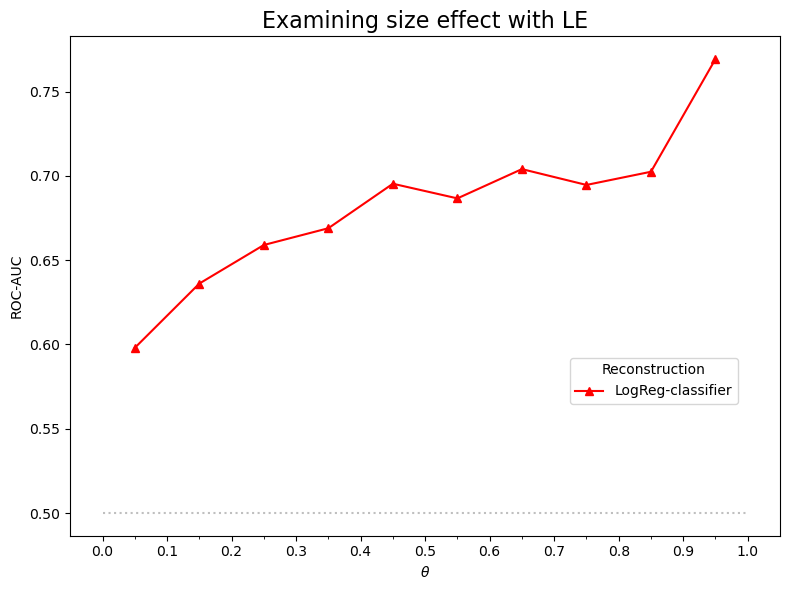

In [23]:
# Instantiate figure, subset relevant data
fig = plt.figure()

# Plotting data
X = sorted(model_performances.keys())
Y = [perfs["auroc"] for perfs in model_performances.values()]
plt.plot(
    X, Y,
    label="LogReg-classifier",
    color="red",
    marker="^"
)

plt.hlines(0.5, 0, 1, linestyles=":", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Reconstruction", loc="lower right", bbox_to_anchor=(0.95, 0.25))
plt.title("Examining size effect with LE")

# Save plot
# plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-method_walklength-20_EMBex35.png")